In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports

##third party###
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt

config.update(
    "jax_enable_x64", True
)  # SHOULDN'T NEED THIS ANYMORE -- but just for safety
plt.style.use(
    "/Users/juan/phd/matplotlib/jdefault.mplstyle"
)  # why do you have to run this twice to work??

import numpy as np  # I guess I need this sometimes

# project
from dynamicAll import models

# Generating Mock Data

In order to test our dynamical models, it'll be good to have a simple way to generate samples from mock systems.

Our main focus will be on sampling stellar systems which don't contribute to the potential, embedded in a dark matter potential.
We'll be taking a pretty brute force approach to sampling, relying on symmetry and our ability to independently sample from the stellar distribution.

### Distribution Functions

In general $f(\vec{x},\vec{v})d^{3}\vec{x}d^{3}\vec{v}$ is the probability of finding a star in the phase space volume $d^{3}\vec{x}d^{3}\vec{v}$.

From the distribution function several relevant quantities can be derived.
For our purposes, the most important will be
$$
p(\vec{x}) = \int f(\vec{x},\vec{v})d^{3}\vec{v}
$$
which will give us the stellar density at a given point in space.

and

$$
p(\vec{v}| \vec{x}) = \frac{f(\vec{x},\vec{v})}{p(\vec{x})}
$$

which is the conditional probability of finding a star with velocity $\vec{v}$ at position $\vec{x}$.
They'll be written in different forms depending on what variables are convenient at the time, but the principle we'll be following is that for various distributions it'll be useful for use to sample $p(\vec{x})$ first, then sample from the conditional distribution $p(\vec{v}|\vec{x})$.

For most system we'll also be setting a limit on the size of the system to be $r_{200}$ which is the radius at which the average density is 200 times the critical density of the universe.

### Isotropic Spherical Distributions

For spherically isotropic systems, following Binney and Tremaine, we can write down the Eddington formula for the distribution function of an isotropic system as
$$
f(\mathcal{E}) = \frac{1}{\sqrt{8}\pi^2}\frac{d}{d\mathcal{E}}\int_{0}^{\infty} \frac{d\psi}{\sqrt{\mathcal{E}-\psi}}\frac{d\rho}{d\psi}.
$$
This is following the normal conventions from Binnery and Tremaine where
$\psi = -\Phi + \Phi_{0}$ and $\mathcal{E} = \psi - \frac{1}{2}v^{2}$.
In cases where a system extends towards infinity, $\Phi_{0} = 0$ and the relative energy $\mathcal{E} = $ binding energy.

An equivalent formula is given by:
$$
f(\mathcal{E}) = \frac{1}{\sqrt{8}\pi^2}\int_{0}^{\infty} \frac{d\psi}{\sqrt{\mathcal{E}-\psi}}\frac{d^{2}\rho}{d\psi^{2}} + \frac{1}{\sqrt{\mathcal{E}}}\left(\frac{d\rho}{d\psi}\right)_{\psi=0}.
$$

For numerical calculations e.g. sampling, it might be easier to not have to calculate $\rho(\psi)$ as it may not be possible to write down in closed form.
Fortunately, $\rho(\psi)$ only appears as a derivative in the above formula we can rewrite it as 

$$
f(\mathcal{E}) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\mathcal{E}}^{\infty} \frac{k(r)dr}{\sqrt{\mathcal{E} - \psi(r)}}
$$


$$d\psi = \frac{d\psi}{dr}dr$$
$$\frac{d}{d\psi}= \frac{dr}{d\psi}\frac{d}{dr} $$
$$\frac{d\psi(r)}{dr} = -\frac{GM(r)}{r^{2}}$$


where k(r)
$$
k(r) = \frac{r^{2}}{GM(r)}\left[\frac{d^{2}\rho}{dr^{2}}(r)\ + \frac{d\rho}{dr}(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)r^{2}}{M(r)}\right)\right]
$$

This is only true for self-consistent systems, where the potential is determined by the density distribution. 

For embedded systems we'll write

$$
k(r) = \frac{r^{2}}{GM_{\rm dm}(r)}\left[\frac{d^{2}\rho_{\star}}{dr^{2}}(r)\ + \frac{d\rho_{\star}}{dr}(r)\left(\frac{2}{r} - \frac{4\pi\rho_{\rm dm}(r)r^{2}}{M_{\rm dm}(r)}\right)\right]
$$

### sampling from position space.

We'll start by generatin a sample of N points (x,y,z) from the probabilty density $p(\vec{x})$.
Spherical symmetry implies that the distribution function is only a function of the radius $r = \sqrt{x^{2} + y^{2} + z^{2}}$ which allows us to only have to deal with a 1D distribution function $p(r)$. 

To find the probability of a star being located within a spherical shell between radii $r$ and $r + dr$, we integrate the probability density function over the volume of this shell:

$$
P(r) = \int_{r}^{r+dr} \int_{0}^{2\pi} \int_{0}^{\pi} p(r') r'^2 \sin\theta \, d\theta \, d\phi \, dr'
$$

$$
P(r) = 4\pi r^2 p(r) , dr
$$

p(r) in this case will just be the density profile of the system. In theory it should be normalized, i.e M=1 but we'll tend to do that normalization in the sampling step so we dont have to worry about it very much and wont be part of the code, but in general

$$
P(r) = \frac{4\pi r^2 p(r)}{\int_{0}^{r_{max}} 4\pi r^2 p(r) dr}
$$
where $r_{max}$ is the maximum radius of the system. Some models in theory have p(r)> 0 for all r, but in practice we'll be setting a limit on the size of the system to be $r_{200}$ which is the radius at which the average density is 200 times the critical density of the universe.

### Getting velocites from the conditional distribution

We'll be sampling from the conditional distribution $p(\vec{v}|\vec{x})$.
since The system is isotropic, the velocity distribution is also isotropic, so we can write the conditional distribution as $p(v|r)$.
and the probability of a star having a velocity between $v$ and $v + dv$ at a given radius $r$ is given by
$$
P(v|r) = \frac{(4\pi)^{2}r^{2}v^{2}f(r,v)}{4\pi r^{2}\rho(r)}
$$

but since we know $f(\mathcal{E})$ it'll be much more convenient for us to sample instead from

$$
P(\mathcal{E}|r) = \frac{f(\mathcal{E})\sqrt{2(\psi-\mathcal{E})}}{\rho(r)}
$$

Note:

If you're going through the code, you'll notice that $\rho(r)$ isn't anywhere, this because its just a normalizing factor and because nothing else is normalized, we'll just be normalizing the final distribution.

$$
P(\mathcal{E}|r)\sim f(\mathcal{E})\sqrt{2(\psi(r)-\mathcal{E})}
$$


FURTHER NOTE: Before you sample the distribution function, you should plot it to make sure $F(\mathcal{E})$ is positive for all $\mathcal{E}$ since the Eddington formula doesnt guarantee this.

The first example you might think of is a plummer embedded in an NFW halo.
However, that will turn out to be inconsistent and $f(\mathcal{E})$ will be negative for some $\mathcal{E}$.

In [4]:
def analytic_drho_dr(r, M, a):
    # derivative of plummer density with respect to r
    return -3 * M * (5 / 2) * 2 * r * (1 + r**2 / a**2) ** (-7 / 2) / a**5 / 4 / np.pi


def analytic_d2rho_dr2(r, M, a):
    term1 = -15 * M / 4 / jnp.pi / a**5
    term2 = (1 + r**2 / a**2) ** (-7 / 2)
    term3 = 7 * r**2 / a**2
    term4 = (1 + r**2 / a**2) ** (-9 / 2)
    return term1 * (term2 - term3 * term4)

In [5]:
from jaxopt import Bisection


def f(cls, epsilon, rlim):
    """
    Eddington formula for the distribution function of a spherical isotropic system.
    This is using the standard variable names and definitions from Binney & Tremaine (2008) where
    :math:`\psi(r) = -\Phi(r) + \Phi_{0}`  and :math:`\epsilon = \psi - \frac{1}{2}v^{2}`.
    In most cases we'll take \Phi_{0} = 0 in which case :math:`\epsilon` is the binding energy.

    .. math::
        f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\epsilon}^{\infty} \frac{k(r)dr}{\sqrt{\epsilon - \psi(r)}}

    where k(r)

    .. math::
        k(r) = \frac{r^{2}}{GM(r)}\left[\rho''(r)\ + \rho'(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)}{M(r)}\right)\right]

    See the documentation for more details on the derivation and tests.

    Note -- In this integral, if you use too many integration points, you could end up with a NaN.
    256 shhould be more than enough.

    Parameters
    ----------
    epsilon : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    rho = cls.density  # density profile
    drho = jax.vmap(jax.grad(rho))  # first derivative of density wrt r
    d2rho = jax.vmap(jax.grad(jax.grad(rho)))  # second derivative of density wrt r
    mass = jax.vmap(cls.mass)  # mass profiles
    # psi = jax.vmap(cls.potential)  # potential profile
    phi = jax.vmap(cls.potential)  # potential profile
    rho = jax.vmap(cls.density)  # density profile

    def k(x):
        term1 = x**2 / cls.G / mass(x)  # coefficient
        term2 = 2 / x - 4 * jnp.pi * rho(x) * x**2 / mass(x)
        term3 = d2rho(x) + drho(x) * term2

        return term1 * term3

    def integrand(x, epsilon):
        coeff = 1 / jnp.sqrt(8) / jnp.pi**2
        return coeff * k(x) / jnp.sqrt(epsilon + phi(x))

    # find at which radius r_epsilon = psi(r) = epsilon
    def psi_minus_epsilon(x):
        x = jnp.atleast_1d(x)
        return phi(x)[0] * -1 - epsilon

    bisec = Bisection(psi_minus_epsilon, lower=1e-10, upper=rlim, maxiter=50, tol=1e-20)
    r_epsilon = bisec.run().params
    # return r_epsilon

    # Integrate from r_epsilon to infinity
    # use gauss-legendre quadrature
    # change coor
    xi, wi = cls._x256, cls._w256
    x0 = 0.0
    x1 = jnp.pi / 2

    xk = 0.5 * (x1 - x0) * xi + 0.5 * (x1 + x0)
    wk = 0.5 * (x1 - x0) * wi

    return r_epsilon * jnp.sum(
        wk
        * integrand(r_epsilon / jnp.sin(xk), epsilon)
        * jnp.cos(xk)
        / jnp.sin(xk) ** 2
    )


cls = models.Plummer(1e5, 0.25)

f_test = jnp.array([f(cls, i, 100.0) for i in jnp.logspace(-2, 0, 100)])

In [6]:
f_test = jnp.array([f(cls, i, 100.0) for i in jnp.logspace(-2, 0, 100)])

In [7]:
def f_v2(epsilon, r_e):
    """
    Eddington formula for the distribution function of a spherical isotropic system.
    This is using the standard variable names and definitions from Binney & Tremaine (2008) where
    :math:`\psi(r) = -\Phi(r) + \Phi_{0}`  and :math:`\epsilon = \psi - \frac{1}{2}v^{2}`.
    In most cases we'll take \Phi_{0} = 0 in which case :math:`\epsilon` is the binding energy.

    .. math::
        f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\epsilon}^{\infty} \frac{k(r)dr}{\sqrt{\epsilon - \psi(r)}}

    where k(r)

    .. math::
        k(r) = \frac{r^{2}}{GM(r)}\left[\rho''(r)\ + \rho'(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)}{M(r)}\right)\right]

    See the documentation for more details on the derivation and tests.

    Parameters
    ----------
    epsilon : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    rho = cls.density  # density profile
    drho = jax.vmap(jax.grad(rho))  # first derivative of density wrt r
    d2rho = jax.vmap(jax.grad(jax.grad(rho)))  # second derivative of density wrt r
    mass = jax.vmap(cls.mass)  # mass profiles
    # psi = jax.vmap(cls.potential)  # potential profile
    phi = jax.vmap(cls.potential)  # potential profile

    def k(x):
        term1 = x**2 / cls.G / mass(x)
        term2 = 2 / x - 4 * jnp.pi * rho(x) * x**2 / mass(x)
        term3 = d2rho(x) + drho(x) * term2
        return term1 * term3

    def integrand(x, epsilon):
        coeff = 1 / jnp.sqrt(8) / jnp.pi**2
        return coeff * k(x) / jnp.sqrt(epsilon + phi(x))

    coeff = 1 / jnp.sqrt(8) / jnp.pi**2

    def test_integrand(x, epsilon):
        def small():
            delta = jnp.abs(x - r_e)
            term1 = cls.G * mass(x) * delta / x**2
            term2 = delta**2 * (2 * jnp.pi * rho(x) - cls.G * mass(x) / x**3)
            dphi = term1 + term2
            return coeff * k(x) / jnp.sqrt(dphi)

        def large():
            dphi = epsilon + phi(x)
            return coeff * k(x) / jnp.sqrt(dphi)

        return jnp.where(jnp.abs(x - r_e) < 1e-4, small(), large())

    # Integrate from r_epsilon to infinity
    # use gauss-legendre quadrature
    # change coor
    xi, wi = cls._x256, cls._w256
    x0 = 0
    x1 = jnp.pi / 2

    xk = 0.5 * (x1 - x0) * xi + 0.5 * (x1 + x0)
    wk = 0.5 * (x1 - x0) * wi

    # _integrand = test_integrand
    _integrand = integrand

    return r_e * jnp.sum(
        wk * _integrand(r_e / jnp.sin(xk), epsilon) * jnp.cos(xk) / jnp.sin(xk) ** 2
    )


def calculate_re(epsilon, rlim):
    phi = cls.potential

    @jax.jit
    def psi_minus_epsilon(x, eps):
        return phi(x) + eps

    def bisection_solver(eps):
        solver = Bisection(
            lambda x: psi_minus_epsilon(x, eps),
            lower=1e-10,
            upper=rlim,
            maxiter=50,
            tol=1e-20,
            check_bracket=False,
        )
        return solver.run().params

    vectorized_bisect = jax.vmap(bisection_solver)
    r_epsilon = vectorized_bisect(epsilon)
    return r_epsilon


epsilon = jnp.logspace(-4, jnp.log10(-0.99 * cls.potential(0.0)), 2000)
r_e = calculate_re(epsilon, 10000.0)


[Text(0.5, 0, 'r_e'), Text(0, 0.5, 'epsilon')]

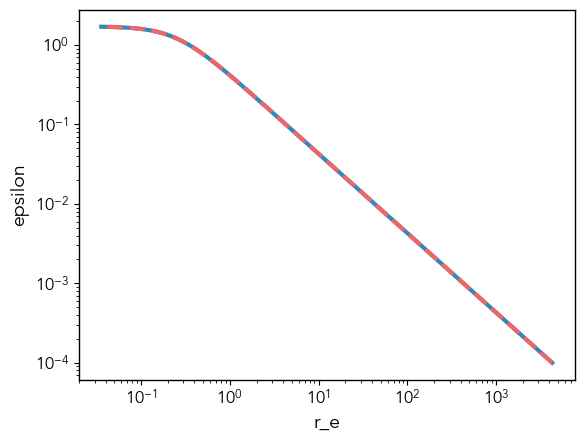

In [9]:
fig, ax = plt.subplots()
ax.plot(r_e, epsilon)
ax.plot(r_e, -cls.potential(r_e), linestyle="--")
ax.set(xscale="log", yscale="log")
ax.set(xlabel="r_e", ylabel="epsilon")

In [10]:
# make sure jax is using float64
print(r_e.dtype)

float64


In [11]:
jnp.log10(-cls.potential(0.0)), -cls.potential(0.0)

(Array(0.23562108, dtype=float64), Array(1.72036691, dtype=float64))

In [12]:
epsilon

Array([1.00000000e-04, 1.00488575e-04, 1.00979537e-04, ...,
       1.68664197e+00, 1.69488247e+00, 1.70316324e+00], dtype=float64)

In [13]:
r_e

Array([4.30091726e+03, 4.28000623e+03, 4.25919687e+03, ...,
       5.02434382e-02, 4.35160181e-02, 3.56230707e-02], dtype=float64)

In [14]:
cls.potential(0.0)

Array(-1.72036691, dtype=float64)

In [15]:
f_test_v2 = jax.vmap(f_v2)(epsilon, r_e)

In [16]:
f_test[-1]

Array(66413.00987105, dtype=float64)

In [17]:
f_test_v2[-1]

Array(428201.87663252, dtype=float64)

In [18]:
def F_plummer(cls, epsilon):
    term1 = 24 * jnp.sqrt(2) * cls._a**2
    term2 = 7 * jnp.pi**3 * cls.G**5 * cls._M**4
    return term1 * epsilon ** (7 / 2) / term2

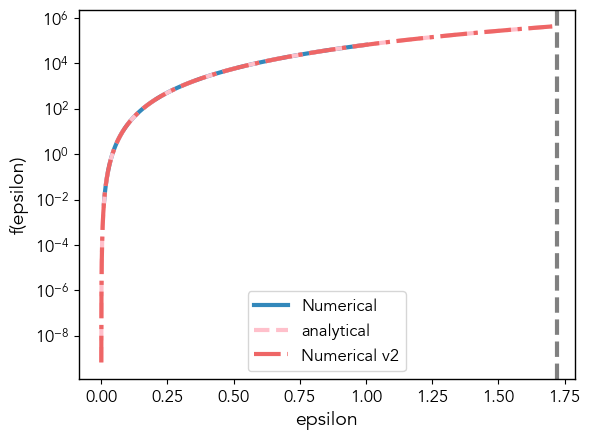

In [19]:
fig, ax = plt.subplots()
# epsilon = jnp.logspace(-2, 0, 100)
# ax.plot(jnp.logspace(-2, 0, 100), (24 * jnp.sqrt(2) / 7) * f_test, label="Numerical")
ax.plot(
    jnp.logspace(-2, 0, 100),
    f_test,
    label="Numerical",
)
# ax.plot(epsilon, (epsilon) ** (7 / 2), linestyle="--")
ax.plot(
    epsilon, F_plummer(cls, epsilon), linestyle="--", label="analytical", color="pink"
)
ax.plot(epsilon, f_test_v2, label="Numerical v2", linestyle="-.")
ax.set(xscale="linear", yscale="log", xlabel="epsilon", ylabel="f(epsilon)")
ax.axvline(-cls.potential(0.0), linestyle="--", color="gray")
ax.legend()

In [20]:
print(f_test_v2)

[6.64130086e-10 6.75556314e-10 6.87179128e-10 ... 4.13839414e+05
 4.20962042e+05 4.28201877e+05]


[None, None]

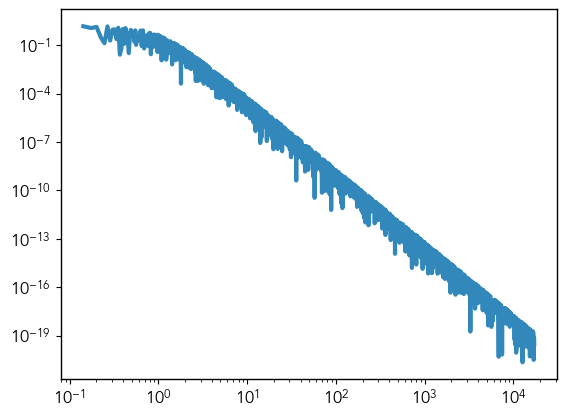

In [22]:
fig, ax = plt.subplots()
ax.plot(r_e / 0.25, jnp.abs(f_test_v2 - F_plummer(cls, epsilon)))
ax.set(xscale="log", yscale="log")
# ax.axvline(-cls.potential(0.25))
# ax.plot(epsilon, jnp.abs(f_test - F_plummer(cls, epsilon)))

In [23]:
nfw = models.NFW(6.4e7, rs=1.0)
plummer = models.Plummer(1e5, 0.25)
hzhao = models.HernquistZhao(1e5, 0.25, 0.1, 2, 5)


def f_v3(epsilon, r_e):
    """
    Eddington formula for the distribution function of a spherical isotropic system.
    This is using the standard variable names and definitions from Binney & Tremaine (2008) where
    :math:`\psi(r) = -\Phi(r) + \Phi_{0}`  and :math:`\epsilon = \psi - \frac{1}{2}v^{2}`.
    In most cases we'll take \Phi_{0} = 0 in which case :math:`\epsilon` is the binding energy.

    .. math::
        f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\epsilon}^{\infty} \frac{k(r)dr}{\sqrt{\epsilon - \psi(r)}}

    where k(r)

    .. math::
        k(r) = \frac{r^{2}}{GM(r)}\left[\rho''(r)\ + \rho'(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)}{M(r)}\right)\right]

    See the documentation for more details on the derivation and tests.

    Parameters
    ----------
    epsilon : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # rho_star = plummer.density  # density profile
    rho_star = hzhao.density  # density profile
    drho_star = jax.vmap(jax.grad(rho_star))  # first derivative of density wrt r
    d2rho_star = jax.vmap(
        jax.grad(jax.grad(rho_star))
    )  # second derivative of density wrt r
    # Dark matter functions we need
    rho_dm = nfw.density
    mass = jax.vmap(nfw.mass)  # mass profiles
    phi = jax.vmap(nfw.potential)  # potential profile
    r200 = nfw.r200()
    rs_dm = nfw._rs
    rhos_dm = nfw._rhos

    def k(x):
        term1 = x**2 / cls.G / mass(x)
        term2 = 2 / x - 4 * jnp.pi * rho_dm(x) * x**2 / mass(x)
        term3 = d2rho_star(x) + drho_star(x) * term2
        return term1 * term3

    def integrand(x, epsilon):
        coeff = 1 / jnp.sqrt(8) / jnp.pi**2
        return coeff * k(x) / jnp.sqrt(epsilon + phi(x))

    coeff = 1 / jnp.sqrt(8) / jnp.pi**2

    def test_integrand(x, epsilon):
        def small():
            delta = jnp.abs(x - r_e)
            term1 = cls.G * mass(x) * delta / x**2
            term2 = delta**2 * (2 * jnp.pi * rho_dm(x) - cls.G * mass(x) / x**3)
            dphi = term1 + term2
            return coeff * k(x) / jnp.sqrt(dphi)

        def large():
            dphi = epsilon + phi(x)
            return coeff * k(x) / jnp.sqrt(dphi)

        return jnp.where(x - r_e < 1e-4, small(), large())

    # Integrate from r_epsilon to infinity
    # use gauss-legendre quadrature
    # change coor
    xi, wi = cls._xk, cls._wk
    r_lim = 1000
    # x0 = jnp.arcsin(r_e / r_lim)
    x0 = 0
    x1 = jnp.pi / 2

    xk = 0.5 * (x1 - x0) * xi + 0.5 * (x1 + x0)
    wk = 0.5 * (x1 - x0) * wi

    _integrand = test_integrand
    # _integrand = integrand

    # return r_lim * jnp.sum(wk * _integrand(r_lim * jnp.sin(xk), epsilon) * jnp.cos(xk))

    return r_e * jnp.sum(
        wk * _integrand(r_e / jnp.sin(xk), epsilon) * jnp.cos(xk) / jnp.sin(xk) ** 2
    )


def calculate_re(epsilon, rlim):
    phi = nfw.potential

    @jax.jit
    def psi_minus_epsilon(x, eps):
        return jnp.abs(phi(x)) - eps

    def bisection_solver(eps):
        solver = Bisection(
            lambda x: psi_minus_epsilon(x, eps),
            lower=1e-12,
            upper=rlim,
            maxiter=100,
            tol=1e-20,
            check_bracket=False,
        )
        return solver.run().params

    vectorized_bisect = jax.vmap(bisection_solver)
    r_epsilon = vectorized_bisect(epsilon)
    return r_epsilon


r200 = nfw.r200()
epsilon = jnp.logspace(
    # jnp.log10(jnp.abs(nfw.potential(r200))),
    -3,
    jnp.log10(4 * jnp.pi * nfw.G * nfw._rhos * nfw._rs**2),
    # jnp.log10(-nfw.potential(1e-10)),
    4000,
)
r_e = calculate_re(epsilon, 1e10)


In [24]:
print(jnp.min(r_e))
print(jnp.max(r_e))


1.3037101757546423e-08
62067420.41022156


In [25]:
4 * jnp.pi * nfw.G * nfw._rhos * nfw._rs**2

3459.0029054063216

In [26]:
print(nfw.potential(1e-10))

-3459.0031914325555


In [27]:
 print(nfw.potential(jnp.max(r_e)))

-0.001


In [28]:
r200 = nfw.r200()

In [29]:
jnp.log10(jnp.abs(nfw.potential(r200))), 4 * jnp.pi * nfw.G * nfw._rhos * nfw._rs**2

(Array(2.64732443, dtype=float64), 3459.0029054063216)

In [30]:
jnp.log

<PjitFunction of <function jax.numpy.log at 0x166e2a480>>

[None, Text(0.5, 0, 'r'), Text(0, 0.5, '$\\Phi(r)$')]

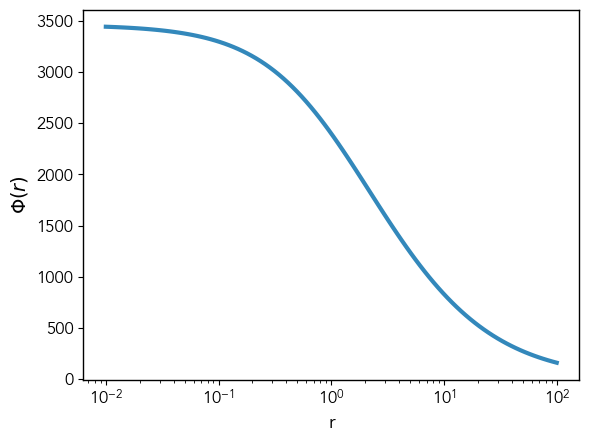

In [31]:
fig, ax = plt.subplots()
r = jnp.logspace(-2, 2, 100)
ax.plot(r, jnp.abs(nfw.potential(r)))
ax.set(xscale="log", xlabel="r", ylabel=r"$\Phi(r)$")


In [32]:
nfw.potential(1e7)

Array(-0.00557525, dtype=float64)

In [33]:
epsilon_max = 4 * jnp.pi * nfw.G * nfw._rhos * nfw._rs**2
epsilon_max

3459.0029054063216

[None]

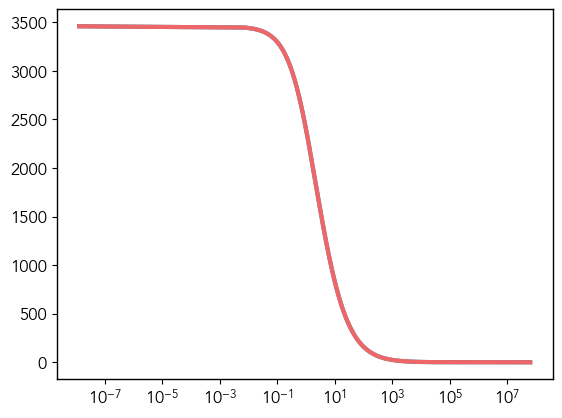

In [34]:
fig, ax = plt.subplots()
ax.plot(r_e, jnp.abs(nfw.potential(r_e)))
ax.plot(r_e, epsilon)
ax.set(xscale="log")

In [35]:
r_e

Array([6.20674204e+07, 6.18204317e+07, 6.15744227e+07, ...,
       1.51550936e-02, 7.55379573e-03, 1.30371018e-08], dtype=float64)

[None, None, Text(0.5, 0, 'epsilon'), Text(0, 0.5, 'r_epsilon')]

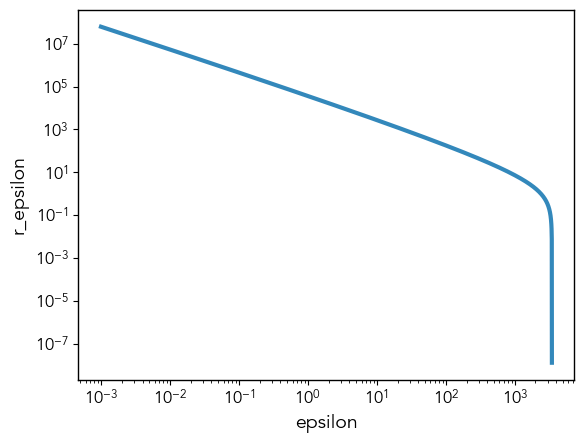

In [36]:
fig, ax = plt.subplots()
ax.plot(epsilon, r_e)
ax.set(xscale="log", yscale="log", xlabel="epsilon", ylabel="r_epsilon")

In [37]:
f_test3 = jax.vmap(f_v3)(epsilon, r_e)

In [38]:
# check that f_test3 is finite everywhere

jnp.all(jnp.isfinite(f_test3))

Array(True, dtype=bool)

In [39]:
f_test3

Array([2.40547313e-33, 2.44014234e-33, 2.47531190e-33, ...,
       3.98278639e+00, 1.39672760e+01, 9.88292144e+07], dtype=float64)

In [40]:
print(epsilon_max)
print(epsilon[-1])

3459.0029054063216
3459.002905406317


In [41]:
jnp.min(f_test3)

Array(2.40547313e-33, dtype=float64)

In [42]:
f_test3[-1]

Array(98829214.35122095, dtype=float64)

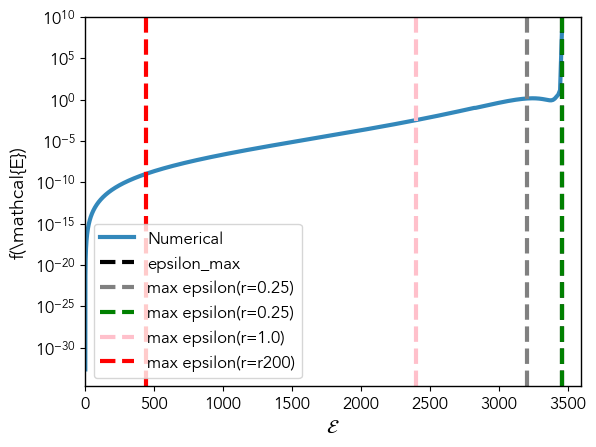

In [43]:
fig, ax = plt.subplots()
ax.plot(epsilon, f_test3, label="Numerical")
ax.axvline(epsilon_max, linestyle="--", color="k", label="epsilon_max")
ax.axvline(
    -nfw.potential(0.64 * 0.25),
    linestyle="--",
    color="gray",
    label="max epsilon(r=0.25)",
)
ax.axvline(
    -nfw.potential(1e-10),
    linestyle="--",
    color="green",
    label="max epsilon(r=0.25)",
)
ax.axvline(
    -nfw.potential(1.0), linestyle="--", color="pink", label="max epsilon(r=1.0)"
)
ax.axvline(
    -nfw.potential(r200), linestyle="--", color="red", label="max epsilon(r=r200)"
)

# ax.set(yscale="log", xlabel=r"$\mathcal{E}$", ylabel="f(\mathcal{E})")
ax.set(xlim=(000, 3600), yscale="log", xlabel=r"$\mathcal{E}$", ylabel="f(\mathcal{E})")
ax.legend()

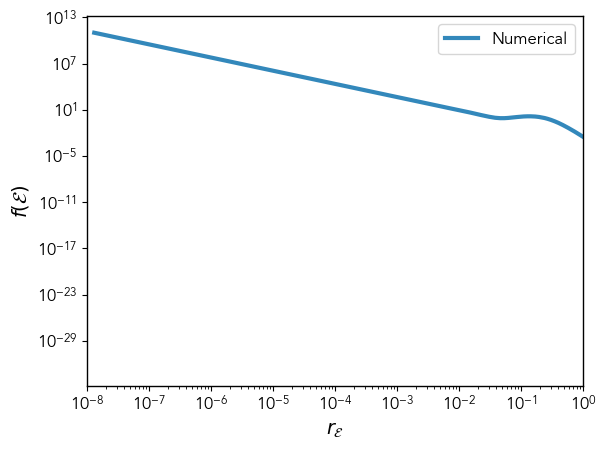

In [413]:
fig, ax = plt.subplots()
ax.plot(r_e, f_test3, label="Numerical")
# ax.axvline(epsilon_max, linestyle="--", color="k", label="epsilon_max")
# ax.axvline(
#     -nfw.potential(0.64 * 0.25),
#     linestyle="--",
#     color="gray",
#     label="max epsilon(r=0.25)",
# )
# ax.axvline(
#     -nfw.potential(1e-10),
#     linestyle="--",
#     color="green",
#     label="max epsilon(r=0.25)",
# )
# ax.axvline(
#     -nfw.potential(1.0), linestyle="--", color="pink", label="max epsilon(r=1.0)"
# )
# ax.axvline(
#     -nfw.potential(r200), linestyle="--", color="red", label="max epsilon(r=r200)"
# )

ax.set(
    xscale="log",
    yscale="log",
    xlim=(1e-8, 1),
    xlabel=r"$r_{\mathcal{E}}$",
    ylabel=r"$f(\mathcal{E})$",
)
# ax.set(
#     xlim=(000, 3600), yscale="symlog", xlabel=r"$\mathcal{E}$", ylabel="f(\mathcal{E})"
# )
ax.legend()

In [ ]:
def P_EpsdEps(cls, epsilon, r):
    """
    Probability of finding a star with relative energy between epsilon and epsilon + d_epsilon at radius r.

    Parameters
    ----------
    epsilon : _type_
        _description_
    r : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """

    def eps_gt_potential(x):
        return 0

    def eps_le_potential(x):
        return cls.f(epsilon) * jnp.sqrt(2 * (epsilon + cls.potential(r)))

    return jax.lax.cond(
        epsilon > cls.potential(r),
        eps_gt_potential,
        eps_le_potential,
    )

In [1317]:
def integrand(x, epsilon):
    """
    Note because of the vmapping i used phi(x)) instead of psi(x)

    Parameters
    ----------
    x : _type_
        _description_
    epsilon : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # use flow control to avoid division by zero

    def small(x, epsilon):
        delta = jnp.abs(x - epsilon)
        term1 = cls.G * mass(x) * delta / x**2
        term2 = delta**2 * (2 * jnp.pi * rho(x) - cls.G * mass(x) / x**3)
        return term1 + term2

    def large(x, epsilon):
        return epsilon + phi(x)

    coeff = 1 / jnp.sqrt(8) / jnp.pi**2

    term = jax.lax.cond(
        x - epsilon < 1e-5,
        lambda x: small(x, epsilon),
        lambda x: large(x, epsilon),
        operand=x,
    )
    return coeff * k(x) / jnp.sqrt(term)

[None, None, Text(0.5, 0, 'epsilon'), Text(0, 0.5, 'f(epsilon)')]

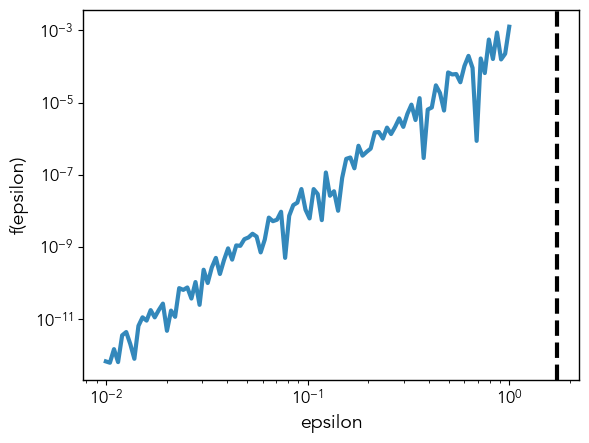

In [36]:
# plot fractional error
fig, ax = plt.subplots()
ax.plot(epsilon, np.abs((f_test - F_plummer(cls, epsilon))))
ax.axvline(cls.G * cls._M / cls._a, linestyle="--", color="k")
ax.set(xscale="log", yscale="log", xlabel="epsilon", ylabel="f(epsilon)")

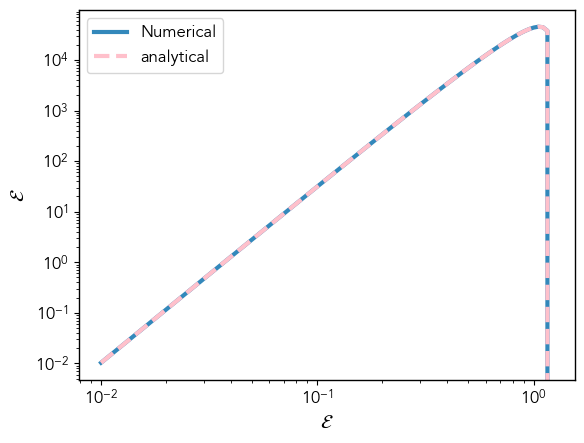

In [12]:
fig, ax = plt.subplots()
r = 0.25
psi = -cls.potential(r)

epsilon = jnp.logspace(-2, jnp.log10(psi), 100)
ax.plot(
    epsilon,
    jnp.array([f(cls, i, 100.0) for i in epsilon]) * jnp.sqrt(2 * (psi - epsilon)),
    label="Numerical",
)
# ax.plot(epsilon, (epsilon) ** (7 / 2), linestyle="--")
ax.plot(
    epsilon,
    F_plummer(cls, epsilon) * jnp.sqrt(2 * (psi - epsilon)),
    linestyle="--",
    color="pink",
    label="analytical",
)

ax.set(
    xscale="log",
    yscale="log",
    xlabel=r"$\mathcal{E}$",
    ylabel=r"$\mathcal{E}$",
)
ax.legend()

In [29]:
f_test

Array([6.64183455e-03, 7.81545980e-03, 9.19826723e-03, 1.08223184e-02,
       1.27388925e-02, 1.49913143e-02, 1.76423057e-02, 2.07612808e-02,
       2.44298398e-02, 2.87474929e-02, 3.38292085e-02, 3.98132485e-02,
       4.68537830e-02, 5.51370038e-02, 6.48924160e-02, 7.63645973e-02,
       8.98624773e-02, 1.05739892e-01, 1.24447957e-01, 1.46441793e-01,
       1.72344975e-01, 2.02811186e-01, 2.38661147e-01, 2.80879930e-01,
       3.30543222e-01, 3.88966763e-01, 4.57780889e-01, 5.38726703e-01,
       6.33938991e-01, 7.46053963e-01, 8.77931851e-01, 1.03315257e+00,
       1.21580326e+00, 1.43087914e+00, 1.68386022e+00, 1.98155906e+00,
       2.33191130e+00, 2.74422294e+00, 3.22932823e+00, 3.80030877e+00,
       4.47223186e+00, 5.26314675e+00, 6.19354294e+00, 7.28865307e+00,
       8.57751988e+00, 1.00942620e+01, 1.18791821e+01, 1.39796224e+01,
       1.64510424e+01, 1.93596130e+01, 2.27831257e+01, 2.68112733e+01,
       3.15512094e+01, 3.71302542e+01, 4.36947429e+01, 5.14209638e+01,
      

In [30]:
def f_v2(epsilon, r_e):
    """
    Eddington formula for the distribution function of a spherical isotropic system.
    This is using the standard variable names and definitions from Binney & Tremaine (2008) where
    :math:`\psi(r) = -\Phi(r) + \Phi_{0}`  and :math:`\epsilon = \psi - \frac{1}{2}v^{2}`.
    In most cases we'll take \Phi_{0} = 0 in which case :math:`\epsilon` is the binding energy.

    .. math::
        f(\epsilon) = \frac{1}{\sqrt{8}\pi^2}\int_{r_\epsilon}^{\infty} \frac{k(r)dr}{\sqrt{\epsilon - \psi(r)}}

    where k(r)

    .. math::
        k(r) = \frac{r^{2}}{GM(r)}\left[\rho''(r)\ + \rho'(r)\left(\frac{2}{r} - \frac{4\pi\rho(r)}{M(r)}\right)\right]

    See the documentation for more details on the derivation and tests.

    Parameters
    ----------
    epsilon : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    rho = cls.density  # density profile
    drho = jax.vmap(jax.grad(rho))  # first derivative of density wrt r
    d2rho = jax.vmap(jax.grad(jax.grad(rho)))  # second derivative of density wrt r
    mass = jax.vmap(cls.mass)  # mass profiles
    # psi = jax.vmap(cls.potential)  # potential profile
    psi = jax.vmap(cls.potential)  # potential profile

    def k(x):
        term1 = x**2 / cls.G / mass(x)
        term2 = 2 / x - 4 * jnp.pi * rho(x) * x**2 / mass(x)
        term3 = d2rho(x) + drho(x) * term2

        return term1 * term3

    def integrand(x, epsilon):
        coeff = 1 / jnp.sqrt(8) / jnp.pi**2
        return coeff * k(x) / jnp.sqrt(epsilon - psi(x))

    # Integrate from r_epsilon to infinity
    # use gauss-legendre quadrature
    # change coor
    xi, wi = cls._x256, cls._w256
    x0 = 0
    x1 = jnp.pi / 2

    xk = 0.5 * (x1 - x0) * xi + 0.5 * (x1 + x0)
    wk = 0.5 * (x1 - x0) * wi

    return r_e * jnp.sum(
        wk * integrand(r_e / jnp.sin(xk), epsilon) * jnp.cos(xk) / jnp.sin(xk) ** 2
    )


In [21]:
def calculate_re(epsilon, rlim):
    psi = cls.potential

    @jax.jit
    def psi_minus_epsilon(x, eps):
        return psi(x) + eps

    def bisection_solver(eps):
        solver = Bisection(
            lambda x: psi_minus_epsilon(x, eps),
            lower=1e-10,
            upper=rlim,
            maxiter=50,
            tol=1e-12,
            check_bracket=False,
        )
        return solver.run().params

    vectorized_bisect = jax.vmap(bisection_solver)
    r_epsilon = vectorized_bisect(epsilon)
    return r_epsilon


r_e = calculate_re(epsilon, 1000.0)

In [ ]:
cls = models.Plummer(1e5, 0.25)

In [22]:
print(r_e)

[43.0084461  41.05357823 39.1875589  37.40634965 35.70609558 34.08311697
 32.53390137 31.05509595 29.64350026 28.29605931 27.00985696 25.7821096
 24.61016012 23.49147219 22.42362472 21.40430666 20.43131202 19.502535
 18.61596556 17.76968497 16.96186169 16.19074743 15.45467334 14.7520464
 14.08134597 13.44112053 12.82998447 12.24661519 11.68975015 11.15818416
 10.65076682 10.16639996  9.70403532  9.26267222  8.84135548  8.43917328
  8.05525519  7.68877035  7.33892561  7.00496381  6.68616219  6.38183081
  6.09131101  5.81397404  5.54921969  5.29647496  5.05519286  4.82485119
  4.60495143  4.39501767  4.19459554  4.00325128  3.82057077  3.64615861
  3.47963734  3.32064652  3.16884205  3.02389536  2.88549269  2.75333449
  2.62713468  2.50662006  2.39152976  2.28161461  2.17663664  2.07636855
  1.98059321  1.88910319  1.80170034  1.71819529  1.63840711  1.56216286
  1.48929724  1.4196522   1.35307663  1.28942598  1.22856197  1.17035225
  1.11467014  1.0613943   1.01040845  0.96160112  0.914

In [121]:
print(jax.vmap(f_v2)(epsilon, r_e))

[1.35817838e-03 1.59832055e-03 1.88092272e-03 2.21349234e-03
 2.60486425e-03 3.06543538e-03 3.60744099e-03 4.24527968e-03
 4.99589587e-03 5.87922997e-03 6.91874810e-03 8.14206546e-03
 9.58167995e-03 1.12758355e-02 1.32695380e-02 1.56157509e-02
 1.83768023e-02 2.16260406e-02 2.54497831e-02 2.99496089e-02
 3.52450577e-02 4.14768052e-02 4.88104001e-02 5.74406622e-02
 6.75968579e-02 7.95487903e-02 9.36139672e-02 1.10166036e-01
 1.29644707e-01 1.52567441e-01 1.79543188e-01 2.11288570e-01
 2.48646915e-01 2.92610661e-01 3.44347723e-01 4.05232517e-01
 4.76882469e-01 5.61200989e-01 6.60428032e-01 7.77199602e-01
 9.14617781e-01 1.07633314e+00 1.26664170e+00 1.49059909e+00
 1.75415483e+00 2.06431037e+00 2.42930511e+00 2.85883529e+00
 3.36431154e+00 3.95916204e+00 4.65918921e+00 5.48298955e+00
 6.45244763e+00 7.59331750e+00 8.93590679e+00 1.05158819e+01
 1.23752155e+01 1.45633015e+01 1.71382673e+01 2.01685178e+01
 2.37345529e+01 2.79311055e+01 3.28696588e+01 3.86814073e+01
 4.55207425e+01 5.356935

In [98]:
# class EmbeddedStellarInPotential(dynamicAll.JaxPotential):
#     def _init__(self, stellarModel, Potential):
#         self.stellarModel = stellarModel
#         self.Potential = Potential


1.7203669080145105


[None, Text(0.5, 0, 'r'), Text(0, 0.5, '$\\frac{d^{2}\\rho}{dr^{2}}$')]

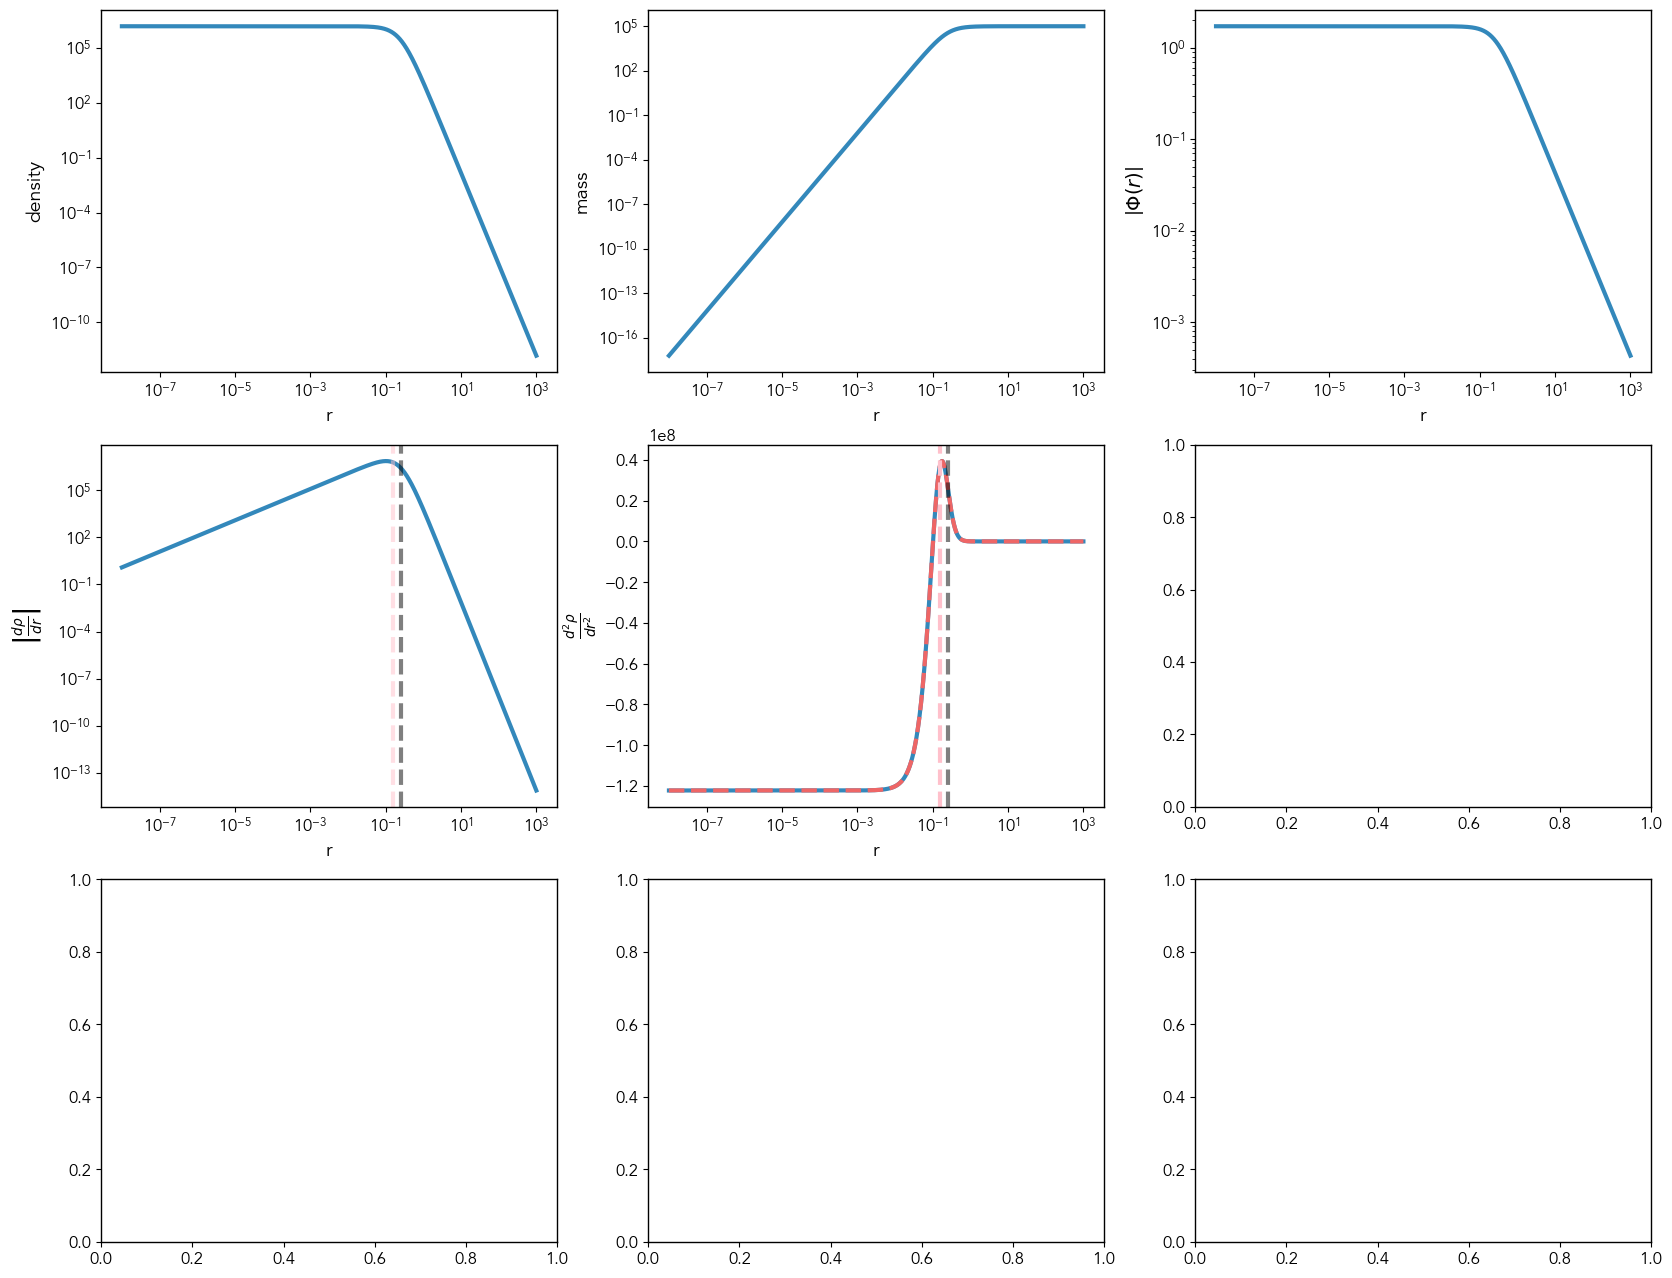

In [58]:
import matplotlib.pyplot as plt

cls = models.Plummer(1e5, 0.25)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16))
lw = 3
ax = ax.flatten()
r = jnp.logspace(-8, 3, 10_000)
ax[0].plot(r, cls.density(r), lw=lw)
ax[0].set(xscale="log", yscale="log", xlabel="r", ylabel="density")
ax[1].plot(r, cls.mass(r), lw=lw)
ax[1].set(xscale="log", yscale="log", xlabel="r", ylabel="mass")
# ax[2].plot(r, jnp.abs(cls.potential(r)), lw=lw)
ax[2].plot(r, jnp.abs(cls.potential(r)), lw=lw)
print(jnp.max(jnp.abs(cls.potential(r))))
ax[2].set(xscale="log", yscale="log", xlabel="r", ylabel=r"$\left|\Phi(r)\right|$")
drho = jax.grad(cls.density)
ax[3].plot(r, jnp.abs(jax.vmap(drho)(r)), lw=lw)
ax[3].axvline(cls._a, color="k", linestyle="--", alpha=0.5)
ax[3].axvline(0.64 * cls._a, color="k", linestyle="--", c="pink", alpha=0.5)
ax[3].set(
    xscale="log", yscale="log", xlabel="r", ylabel=r"$\left|\frac{d\rho}{dr}\right|$"
)
d2rho = jax.vmap(jax.grad(drho))
# ax[4].plot(r, jnp.abs(d2rho(r)), lw=lw)
# ax[4].plot(r, jnp.abs(analytic_d2rho_dr2(r, cls._M, cls._a)), lw=lw, linestyle="--")
ax[4].plot(r, d2rho(r), lw=lw)
ax[4].plot(r, analytic_d2rho_dr2(r, cls._M, cls._a), lw=lw, linestyle="--")
ax[4].axvline(0.64 * cls._a, color="k", linestyle="--", c="pink", alpha=1.0)

ax[4].axvline(cls._a, color="k", linestyle="--", alpha=0.5)
ax[4].set(
    xscale="log",
    # yscale="log",
    xlabel="r",
    # ylabel=r"$\left|\frac{d^{2}\rho}{dr^{2}}\right|$",
    ylabel=r"$\frac{d^{2}\rho}{dr^{2}}$",
)

In [123]:
import jax
import jax.numpy as jnp
from dynamicAll import models
# from functools import partial

# DF_test = jax.vmap(f, in_axes=(0, None, 0))

cls = models.Plummer(1e5, 0.25)

f_test = jnp.array([f(cls, i, 100.0) for i in jnp.logspace(-2, 0, 100)])

In [124]:
f_test

Array([1.35817840e-03, 1.59832054e-03, 1.88092275e-03, 2.21349228e-03,
       2.60486430e-03, 3.06543544e-03, 3.60744107e-03, 4.24527976e-03,
       4.99589589e-03, 5.87922992e-03, 6.91874799e-03, 8.14206545e-03,
       9.58167998e-03, 1.12758355e-02, 1.32695382e-02, 1.56157511e-02,
       1.83768024e-02, 2.16260402e-02, 2.54497831e-02, 2.99496086e-02,
       3.52450578e-02, 4.14768050e-02, 4.88103995e-02, 5.74406623e-02,
       6.75968580e-02, 7.95487896e-02, 9.36139680e-02, 1.10166037e-01,
       1.29644707e-01, 1.52567442e-01, 1.79543188e-01, 2.11288569e-01,
       2.48646913e-01, 2.92610663e-01, 3.44347725e-01, 4.05232518e-01,
       4.76882470e-01, 5.61200991e-01, 6.60428029e-01, 7.77199598e-01,
       9.14617776e-01, 1.07633314e+00, 1.26664169e+00, 1.49059909e+00,
       1.75415483e+00, 2.06431037e+00, 2.42930512e+00, 2.85883531e+00,
       3.36431155e+00, 3.95916203e+00, 4.65918922e+00, 5.48298956e+00,
       6.45244762e+00, 7.59331750e+00, 8.93590677e+00, 1.05158819e+01,
      

In [61]:
f_test

Array([1.35817840e-03, 1.59832054e-03, 1.88092275e-03, 2.21349228e-03,
       2.60486430e-03, 3.06543544e-03, 3.60744107e-03, 4.24527976e-03,
       4.99589589e-03, 5.87922992e-03, 6.91874799e-03, 8.14206545e-03,
       9.58167998e-03, 1.12758355e-02, 1.32695382e-02, 1.56157511e-02,
       1.83768024e-02, 2.16260402e-02, 2.54497831e-02, 2.99496086e-02,
       3.52450578e-02, 4.14768050e-02, 4.88103995e-02, 5.74406623e-02,
       6.75968580e-02, 7.95487896e-02, 9.36139680e-02, 1.10166037e-01,
       1.29644707e-01, 1.52567442e-01, 1.79543188e-01, 2.11288569e-01,
       2.48646913e-01, 2.92610663e-01, 3.44347725e-01, 4.05232518e-01,
       4.76882470e-01, 5.61200991e-01, 6.60428029e-01, 7.77199598e-01,
       9.14617776e-01, 1.07633314e+00, 1.26664169e+00, 1.49059909e+00,
       1.75415483e+00, 2.06431037e+00, 2.42930512e+00, 2.85883531e+00,
       3.36431155e+00, 3.95916203e+00, 4.65918922e+00, 5.48298956e+00,
       6.45244762e+00, 7.59331750e+00, 8.93590677e+00, 1.05158819e+01,
      

Array(13581.78376429, dtype=float64)

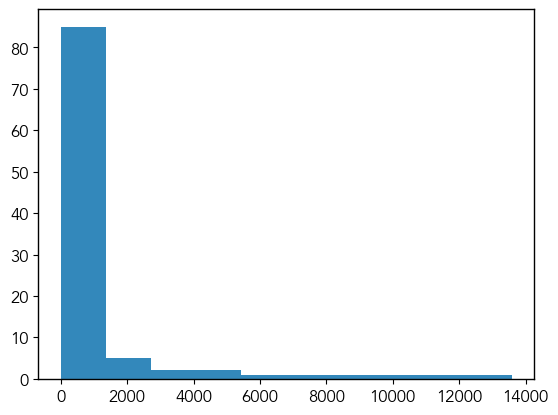

In [21]:
plt.hist(f_test)
max(f_test)

In [15]:
def F_plummer(cls, epsilon):
    term1 = 24 * jnp.sqrt(2) * cls._a**2
    term2 = 7 * jnp.pi**3 * cls.G**5 * cls._M**4
    return term1 * epsilon ** (7 / 2) / term2

In [63]:
term1 = 24 * jnp.sqrt(2) * cls._a**2
term2 = 7 * jnp.pi**3 * cls.G**5 * cls._M**4
print(term1 / term2)

66413.00859875184


In [64]:
24 * jnp.sqrt(2) / 7

Array(4.84873221, dtype=float64, weak_type=True)

In [540]:
print(1e-3)
print(nfw.potential(1e-3))
print(epsilon_max)

0.001
-3457.274556090147
3459.0029054063216


In [65]:
cls.potential(0.25)

Array(-1.21648311, dtype=float64)

In [66]:
for c, i in enumerate(jnp.logspace(-2, 0, 100)):
    print(i, f_test[c])

0.01 0.0013581783954212006
0.010476157527896646 0.0015983205432077371
0.010974987654930561 0.001880922752266257
0.011497569953977356 0.0022134922808039253
0.012045035402587823 0.0026048642953121794
0.012618568830660204 0.003065435438153367
0.013219411484660293 0.0036074410727522173
0.013848863713938732 0.004245279761083396
0.014508287784959394 0.004995895890512056
0.01519911082952934 0.0058792299243508525
0.015922827933410922 0.0069187479925119635
0.016681005372000592 0.008142065447713377
0.01747528400007684 0.00958167997780417
0.01830738280295368 0.01127583548059207
0.019179102616724886 0.013269538192975104
0.02009233002565047 0.01561575109991018
0.02104904144512021 0.01837680239483801
0.022051307399030457 0.02162604023149772
0.023101297000831605 0.025449783136446164
0.02420128264794382 0.029949608571966078
0.025353644939701114 0.03524505777164215
0.026560877829466867 0.04147680499507979
0.027825594022071243 0.04881039945412549
0.029150530628251774 0.057440662340877205
0.0305385550883

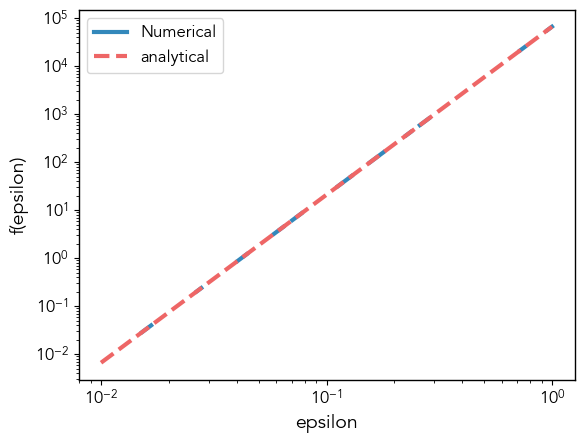

In [31]:
fig, ax = plt.subplots()
epsilon = jnp.logspace(-2, 0, 100)
# ax.plot(jnp.logspace(-2, 0, 100), (24 * jnp.sqrt(2) / 7) * f_test, label="Numerical")
ax.plot(jnp.logspace(-2, 0, 100), f_test, label="Numerical")
# ax.plot(epsilon, (epsilon) ** (7 / 2), linestyle="--")
ax.plot(epsilon, F_plummer(cls, epsilon), linestyle="--", label="analytical")
ax.set(xscale="log", yscale="log", xlabel="epsilon", ylabel="f(epsilon)")
ax.legend()

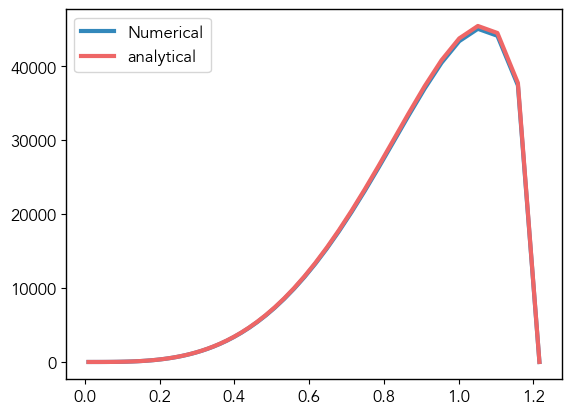

In [68]:
fig, ax = plt.subplots()
r = 0.25
psi = -cls.potential(r)

epsilon = jnp.logspace(-2, jnp.log10(psi), 100)
ax.plot(
    epsilon,
    (24 * jnp.sqrt(2) / 7)
    * jnp.array([f(cls, i, 100.0) for i in epsilon])
    * jnp.sqrt(2 * (psi - epsilon)),
    label="Numerical",
)
# ax.plot(epsilon, (epsilon) ** (7 / 2), linestyle="--")
ax.plot(
    epsilon,
    F_plummer(cls, epsilon) * jnp.sqrt(2 * (psi - epsilon)),
    # linestyle="--",
    label="analytical",
)

# ax.set(xscale="log", yscale="log", xlabel="epsilon", ylabel="f(epsilon)")
ax.legend()

In [ ]:
def f_max(func, psi):
    """
    Parameters
    ----------
    func : _type_
        _description_
    psi : _type_
        _description_
    """

    def Qfun(epsilon):
        if epsilon > psi:
            return 0
        else:
            result = func(epsilon) * (2 * (psi - epsilon)) ** 0.5
            return -result

    optvar = scipy.optimize.fmin(lambda Q1: Qfun(Q1), (psi * 0.9), disp=False)
    fmax = -Qfun(optvar)
    return optvar, fmax

[(0.9, 100.0),
 None,
 None,
 Text(0.5, 0, 'epsilon'),
 Text(0, 0.5, 'F(epsilon)/f(epsilon)')]

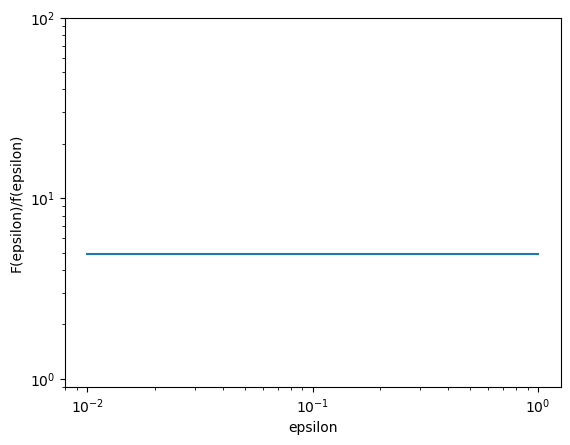

In [252]:
fig, ax = plt.subplots()
ax.plot(epsilon, F_plummer(cls, epsilon) / f_test, label="ratio")
ax.set(
    ylim=(0.9, 100),
    yscale="log",
    xscale="log",
    xlabel="epsilon",
    ylabel="F(epsilon)/f(epsilon)",
)

In [270]:
print(F_plummer(cls, epsilon) / f_test)

[4.88985901 4.88985909 4.889859   4.88985921 4.88985898 4.88985898
 4.88985897 4.88985898 4.88985905 4.88985911 4.88985915 4.88985908
 4.88985906 4.88985908 4.889859   4.88985901 4.88985905 4.88985916
 4.88985906 4.88985913 4.88985907 4.8898591  4.88985914 4.88985906
 4.88985906 4.88985911 4.88985903 4.88985903 4.88985908 4.88985905
 4.88985908 4.88985909 4.88985911 4.88985904 4.88985905 4.88985906
 4.88985907 4.88985906 4.8898591  4.8898591  4.8898591  4.88985907
 4.8898591  4.8898591  4.88985908 4.88985907 4.88985906 4.88985905
 4.88985907 4.88985908 4.88985906 4.88985907 4.88985908 4.88985907
 4.88985909 4.88985908 4.88985907 4.88985908 4.88985906 4.88985908
 4.88985908 4.88985908 4.88985908 4.88985907 4.88985908 4.88985907
 4.88985907 4.88985908 4.88985908 4.88985907 4.88985908 4.88985908
 4.88985908 4.88985907 4.88985907 4.88985907 4.88985908 4.88985907
 4.88985907 4.88985908 4.88985907 4.88985908 4.88985907 4.88985908
 4.88985907 4.88985907 4.88985907 4.88985907 4.88985907 4.8898